In [1]:
# 0. Import Libraries

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 1. Establishing the Microlensing Model

def paczynski_curve(t, t0, tE, u_min):
    """
    Calculates the magnification A at time t.
    """
    # Normalized time parameter
    tau = (t - t0) / tE
    
    # Distance u(t)
    u = np.sqrt(u_min**2 + tau**2)
    
    # Amplification A(u)
    A = (u**2 + 2) / (u * np.sqrt(u**2 + 4))
    return A

In [3]:
# 2. Generate the Data 

def generate_light_curves(n_samples=1000, n_timesteps=100):
    time_axis = np.linspace(0,100, n_timesteps) # Assumption for a 100-day observation

    X_data = [] # Light Curves (flux vs time)
    y_labels = [] # 1 = Black Hole, 0 = Variable Star/Noise

    for _ in range(n_samples):
        # Flip a coin: Is this a Black Hole (1) or just Noise (0)?
        is_lensing = np.random.choice([0, 1])
        
        # Base flux (star brightness before lensing)
        baseline = 1.0

        if is_lensing:
            # Randomize Event Parameters
            t0 = np.random.uniform(20, 80)     # Peak happens randomly
            tE = np.random.uniform(5, 30)      # Duration depends on Mass
            u_min = np.random.uniform(0.05, 1.0) # How close it passes
            
            # Physics signal
            magnification = paczynski_curve(time_axis, t0, tE, u_min)
            flux = baseline * magnification
            
        else:
            # IMPOSTOR: Variable Star (Sinusoidal or Random Walk)
            # This makes the AI work harder. It can't just look for "change".
            mode = np.random.choice(['sine', 'noise'])

            if mode == 'sine':
                period = np.random.uniform(10, 50)
                phase = np.random.uniform(0, 10)
                # Variable star fluctuates by 20%
                flux = baseline + 0.2 * np.sin((time_axis / period) * 2 * np.pi + phase)
            else:
                # Just random atmospheric noise (Flat line)
                flux = np.full_like(time_axis, baseline)

        # Adding Realistic Telescope Noise
        # Photometric error (e.g., 5% uncertainty)
        noise = np.random.normal(0, 0.05, n_timesteps)
        flux_observed = flux + noise
        
        X_data.append(flux_observed)
        y_labels.append(is_lensing)
            
    return np.array(X_data), np.array(y_labels), time_axis

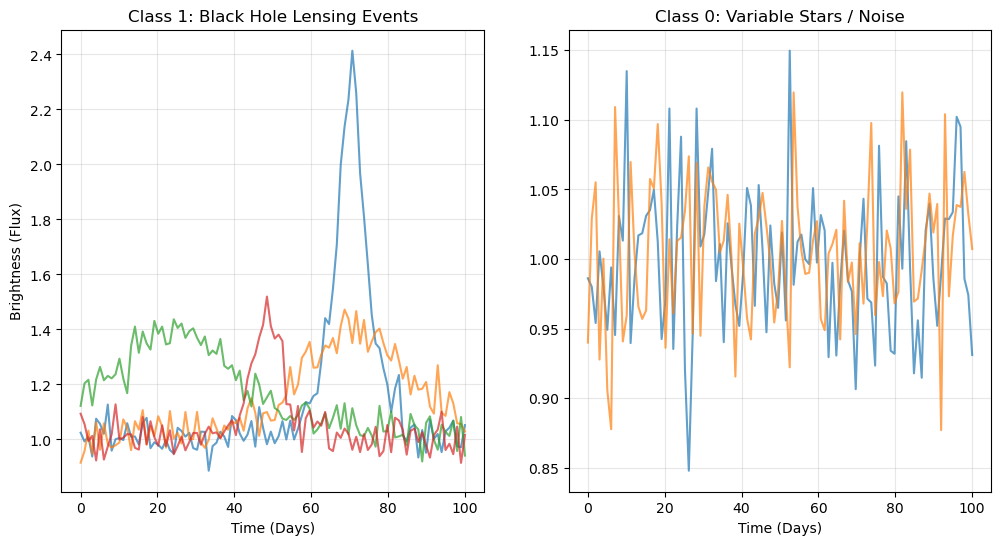

In [6]:
# 3. Visualizations

X_curves, y_labels, t_axis = generate_light_curves(n_samples=6)

plt.figure(figsize=(12, 6))

# Plot a few Black Hole events
plt.subplot(1, 2, 1)
plt.title("Class 1: Black Hole Lensing Events")
for i in range(len(y_labels)):
    if y_labels[i] == 1:
        plt.plot(t_axis, X_curves[i], alpha=0.7)
        # Only plot first 3
        if i > 5: break
plt.xlabel("Time (Days)")
plt.ylabel("Brightness (Flux)")
plt.grid(True, alpha=0.3)

# Plot a few Impostors
plt.subplot(1, 2, 2)
plt.title("Class 0: Variable Stars / Noise")
count = 0
for i in range(len(y_labels)):
    if y_labels[i] == 0:
        plt.plot(t_axis, X_curves[i], alpha=0.7)
        count += 1
        if count >= 3: break
plt.xlabel("Time (Days)")
plt.grid(True, alpha=0.3)

plt.show()

In [7]:
# B. Time-Series AI (LST) ~ Long Short-Term Memory

# 0. Import libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [8]:
# 1. Prepare the data

# Generate 5,000 light curves (100 days each)
print("Simulating 5,000 stellar light curves...")
X, y, t_axis = generate_light_curves(n_samples=5000, n_timesteps=100)

# Reshape for LSTM: [Samples, TimeSteps, Features]
# We have 1 feature (Brightness/Flux) per time step
X = X.reshape(5000, 100, 1)

# Split into Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training Data Shape: {X_train.shape}") # Should be (4000, 100, 1)

Simulating 5,000 stellar light curves...
Training Data Shape: (4000, 100, 1)


In [9]:
# 2. Build the LSTM Model
model = Sequential([
    # Layer 1: LSTM
    # 64 units = The "memory capacity" of the network
    # return_sequences=False -> We only want the final decision after seeing the whole curve
    LSTM(64, input_shape=(100, 1)),
    
    # Dropout to prevent overfitting (randomly forget 20% of connections)
    Dropout(0.2),
    
    # Layer 2: Decision Head
    # 32 Neurons for reasoning
    Dense(32, activation='relu'),
    
    # Layer 3: Output (Binary Classification)
    # Sigmoid -> Output probability between 0 (Star) and 1 (Black Hole)
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy', # Standard for Yes/No questions
              metrics=['accuracy'])

D:\zz - Rizchel\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [10]:
# 4. Train
print("\nTraining LSTM on Time-Domain Data...")
history = model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2, verbose=1)


Training LSTM on Time-Domain Data...
Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.5065 - loss: 0.6836 - val_accuracy: 1.0000 - val_loss: 0.3140
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8612 - loss: 0.4447 - val_accuracy: 0.5038 - val_loss: 0.7443
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4901 - loss: 0.7244 - val_accuracy: 0.5038 - val_loss: 0.6942
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.5026 - loss: 0.6935 - val_accuracy: 0.4950 - val_loss: 0.6928
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5102 - loss: 0.6920 - val_accuracy: 0.4950 - val_loss: 0.6910
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5131 - loss: 0.6897 - val_accuracy: 0.4963 - val_loss: 0.6732
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6689 - loss: 0.6098 - val_accuracy: 0.5263 - val_loss: 0.7222
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.6053 - 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 1.0000 - loss: 0.2339

Final Test Accuracy: 100.00%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step

Sample #5:
True Label: Black Hole
AI Prediction: 0.9928 (Black Hole)


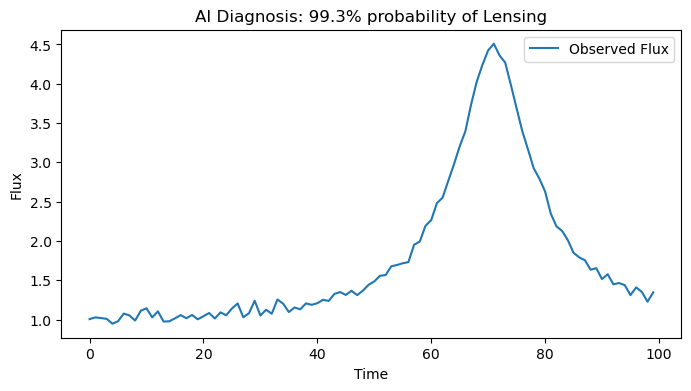

In [11]:
# 5. Evaluate

# Let's test it on the unseen test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"\nFinal Test Accuracy: {accuracy*100:.2f}%")

# Let's look at a specific prediction
test_sample_idx = 5
prediction_prob = model.predict(X_test[test_sample_idx].reshape(1, 100, 1))[0][0]
true_label = y_test[test_sample_idx]

print(f"\nSample #{test_sample_idx}:")
print(f"True Label: {'Black Hole' if true_label==1 else 'Variable Star'}")
print(f"AI Prediction: {prediction_prob:.4f} ({'Black Hole' if prediction_prob > 0.5 else 'Variable Star'})")

# Plot that specific sample
plt.figure(figsize=(8, 4))
plt.plot(X_test[test_sample_idx], label='Observed Flux')
plt.title(f"AI Diagnosis: {prediction_prob:.1%} probability of Lensing")
plt.xlabel("Time")
plt.ylabel("Flux")
plt.legend()
plt.show()

In [12]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. Imbalanced Data Generator
def generate_imbalanced_data(n_samples=5000, anomaly_rate=0.01):
    """
    Generates data where Black Holes are rare (anomaly_rate).
    """
    print(f"Generating {n_samples} light curves with only {anomaly_rate*100}% Black Holes...")
    
    X_data = []
    y_labels = []
    t_axis = np.linspace(0, 100, 100)
    
    n_anomalies = int(n_samples * anomaly_rate)
    n_normal = n_samples - n_anomalies
    
    # Create the "Normal" stars (Variable/Noise)
    for _ in range(n_normal):
        # ... (Same noise logic as before) ...
        baseline = 1.0
        mode = np.random.choice(['sine', 'noise'])
        if mode == 'sine':
            period = np.random.uniform(10, 50)
            phase = np.random.uniform(0, 10)
            flux = baseline + 0.2 * np.sin((t_axis / period) * 2 * np.pi + phase)
        else:
            flux = np.full_like(t_axis, baseline)
            
        noise = np.random.normal(0, 0.05, 100)
        X_data.append(flux + noise)
        y_labels.append(0) # Label 0 = Boring Star
        
    # Create the "Anomalies" (Black Holes)
    for _ in range(n_anomalies):
        # ... (Same lensing logic) ...
        baseline = 1.0
        t0 = np.random.uniform(20, 80)
        tE = np.random.uniform(5, 30)
        u_min = np.random.uniform(0.05, 1.0)
        
        magnification = paczynski_curve(t_axis, t0, tE, u_min)
        flux = baseline * magnification
        noise = np.random.normal(0, 0.05, 100)
        
        X_data.append(flux + noise)
        y_labels.append(1) # Label 1 = Black Hole (Rare!)
        
    # Shuffle them! (Otherwise all BHs are at the end)
    X_data = np.array(X_data)
    y_labels = np.array(y_labels)
    
    perm = np.random.permutation(len(X_data))
    return X_data[perm], y_labels[perm]

In [13]:
# 2. The Stress Test 
# 5000 stars, but only ~50 are Black Holes
X_imbalance, y_imbalance = generate_imbalanced_data(n_samples=5000, anomaly_rate=0.02)
X_imbalance = X_imbalance.reshape(5000, 100, 1)

# Split
X_train_imb, X_test_imb, y_train_imb, y_test_imb = train_test_split(X_imbalance, y_imbalance, test_size=0.2, random_state=42)

# Train the LSTM on this hard data
print("Training LSTM on imbalanced data...")
# We use 'class_weight' to tell the AI: "Finding a 1 is 50x more important than finding a 0"
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_imb), y=y_train_imb)
class_weights = {0: weights[0], 1: weights[1]}

model.fit(X_train_imb, y_train_imb, epochs=10, batch_size=64, class_weight=class_weights, verbose=0)
print("Training Complete.")

Generating 5000 light curves with only 2.0% Black Holes...
Training LSTM on imbalanced data...
Training Complete.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


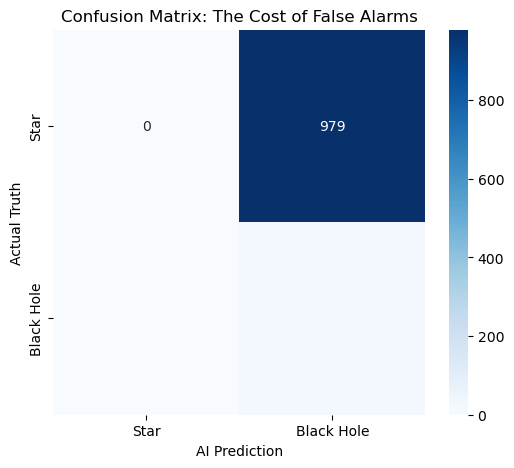

              precision    recall  f1-score   support

        Star       0.00      0.00      0.00       979
  Black Hole       0.02      1.00      0.04        21

    accuracy                           0.02      1000
   macro avg       0.01      0.50      0.02      1000
weighted avg       0.00      0.02      0.00      1000



D:\zz - Rizchel\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\zz - Rizchel\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\zz - Rizchel\Anaconda\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [14]:
# 3. The Confusion Matrix 
y_pred_prob = model.predict(X_test_imb)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test_imb, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Star', 'Black Hole'], yticklabels=['Star', 'Black Hole'])
plt.ylabel('Actual Truth')
plt.xlabel('AI Prediction')
plt.title('Confusion Matrix: The Cost of False Alarms')
plt.show()

# Print the "Real" metrics
print(classification_report(y_test_imb, y_pred, target_names=['Star', 'Black Hole']))